In [116]:
# Import dependencies
import importlib
import torch
import torch.nn as nn
from torch.nn import Linear
import torch.nn.functional as F
import pickle
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import altair as alt
import SCL
importlib.reload(SCL)

<module 'SCL' from 'C:\\Users\\nicho\\Desktop\\Milestone II\\SCL.py'>

In [2]:
with open('temp_0_val.pkl', 'rb') as file:
    temp_0_val = pickle.load(file)
with open('temp_0_val_targs.pkl', 'rb') as file:
    temp_0_val_targs = pickle.load(file)
    
with open('temp_7_val.pkl', 'rb') as file:
    temp_7_val = pickle.load(file)
with open('temp_7_val_targs.pkl', 'rb') as file:
    temp_7_val_targs = pickle.load(file)

with open('temp_14_val.pkl', 'rb') as file:
    temp_14_val = pickle.load(file)
with open('temp_14_val_targs.pkl', 'rb') as file:
    temp_14_val_targs = pickle.load(file)

with open('temp_all_val.pkl', 'rb') as file:
    temp_all_val = pickle.load(file)
with open('temp_all_val_targs.pkl', 'rb') as file:
    temp_all_val_targs = pickle.load(file)

## Bootstrapping

One way to evaluate model performance is to bootstrap the unseen data in the test set and aggregate model accuracies across many samples.

In [3]:
class WordEmbeddingDataset(Dataset):
    """
    Custom dataset object to feed into the dataloader
    """
    def __init__(self, embs, targs):
        """
        Class initializer

        embs: concatenated CLS embeddings and feature vectors
        targs: base truth model numbers
        """
        self.embs = embs
        self.targs = targs 

    def __len__(self):
        return len(self.embs)

    def __getitem__(self, idx):
        """
        Method used by data loader to output data
        
        idx: random batch index from dataloader

        Returns: 
        Tuple with batch embeddings at [0] and batch base truth targets at [1]
        """
        return self.embs[idx], self.targs[idx]

In [92]:
BATCH_SIZE = 100
dataset_0 = WordEmbeddingDataset(temp_0_val, temp_0_val_targs)
dataset_7 = WordEmbeddingDataset(temp_7_val, temp_7_val_targs)
dataset_14 = WordEmbeddingDataset(temp_14_val, temp_14_val_targs)
dataset_all = WordEmbeddingDataset(temp_all_val, temp_all_val_targs)

data_loader_0_val = DataLoader(dataset_0, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
data_loader_7_val = DataLoader(dataset_7, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
data_loader_14_val = DataLoader(dataset_14, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
data_loader_all_val = DataLoader(dataset_all, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

In [4]:
class Classifier(nn.Module):
    def __init__(self, hidden_size, num_class, hidden_dropout_prob):
        super().__init__()
        self.dropout = nn.Dropout(hidden_dropout_prob)
        self.fc = nn.Linear(hidden_size, num_class)
        self.init_weights()

    def init_weights(self):
        initrange = 0.02
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, feature):
        return self.fc(torch.tanh(feature))

In [5]:
class FAM(nn.Module):
    def __init__(self, embed_size, hidden_size, hidden_dropout_prob):
        super().__init__()
        self.dropout = nn.Dropout(hidden_dropout_prob)
        self.fc = nn.Linear(embed_size, hidden_size)
        
    def init_weights(self):
        initrange = 0.2
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()


    def forward(self, text):
        batch,  dim = text.size()
        feat = self.fc(torch.tanh(self.dropout(text.view(batch, dim))))
        feat = F.normalize(feat, dim=1)
        return feat

In [6]:
class Model():
    def __init__(self, embs, targs, model_filepath):
        RANDOM_STATE = 42
        HIDDEN_SIZE = 256
        DROPOUT_PERCENT = 0.3
        NUM_FEATURES = 797
        NUM_CLASSES = 3
        model_data = torch.load(model_filepath)
        self.fam = FAM(NUM_FEATURES, HIDDEN_SIZE, DROPOUT_PERCENT)
        self.classifier = Classifier(HIDDEN_SIZE, NUM_CLASSES, DROPOUT_PERCENT)
        self.fam.load_state_dict(model_data['fam_state_dict'])
        self.classifier.load_state_dict(model_data['classifier_state_dict'])
        self.embs = embs
        self.targs = targs
        self.rng = np.random.default_rng(RANDOM_STATE)
        
        
    def get_bootstrap_dataloader(self):
        BATCH_SIZE = 100
        np.random.seed(42)
        num_samples = len(self.embs)
        bootstrap_indices = self.rng.choice(np.arange(num_samples), size=num_samples, replace=True)
        sample_embs = [self.embs[idx] for idx in bootstrap_indices]
        sample_targs = [self.targs[idx] for idx in bootstrap_indices]
        dataset = WordEmbeddingDataset(sample_embs, sample_targs)
        data_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
        return data_loader


    def evaluate(self, data_loader):
        # Set networks to eval mode
        self.fam.eval()  
        self.classifier.eval()
    
        correct = 0
        total = 0
    
        with torch.no_grad():  
            for data in data_loader:
                embs = data[0].squeeze(1)  
                targets = data[1].tolist()
                
                fam_output = self.fam(embs)
                final_output = self.classifier(fam_output)
                preds = final_output.argmax(1).tolist()
                
                total += len(preds) 
                correct += np.sum(np.array(preds) == np.array(targets))  
    
        accuracy = correct / total
        return accuracy

    def run_bootstrap(self, num_iterations):
        accuracies = []
        for _ in tqdm(range(num_iterations)):
            data_loader = self.get_bootstrap_dataloader()
            accuracy = self.evaluate(data_loader)
            accuracies.append(accuracy)
        return accuracies

In [7]:
temp_0_model = Model(temp_0_val, temp_0_val_targs, 'temp_0_models.pth')
temp_0_accuracy = temp_0_model.run_bootstrap(10000)

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:32<00:00, 311.24it/s]


In [8]:
temp_7_model = Model(temp_7_val, temp_7_val_targs, 'temp_7_models.pth')
temp_7_accuracy = temp_7_model.run_bootstrap(10000)

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:40<00:00, 245.66it/s]


In [9]:
temp_14_model = Model(temp_14_val, temp_14_val_targs, 'temp_14_models.pth')
temp_14_accuracy = temp_14_model.run_bootstrap(10000)

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 313.68it/s]


In [10]:
temp_all_model = Model(temp_all_val, temp_all_val_targs, 'temp_all_models.pth')
temp_all_accuracy = temp_all_model.run_bootstrap(10000)

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [01:51<00:00, 89.48it/s]


In [11]:
data = {'temp_0':temp_0_accuracy, 'temp_7':temp_7_accuracy, 'temp_14':temp_14_accuracy, 'temp_all':temp_all_accuracy}
bootstrap_df = pd.DataFrame(data)

In [12]:
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

In [13]:

histogram_0 = alt.Chart(bootstrap_df).mark_line(opacity=0.7, color='blue').encode(
    alt.X('temp_0:Q', bin=True, title='Accuracy'),
    alt.Y('count():Q', title='Frequency')  
)

histogram_7 = alt.Chart(bootstrap_df).mark_line(opacity=0.7, color='red').encode(
    alt.X('temp_7:Q', bin=True, title='Accuracy'),
    alt.Y('count():Q', title='Frequency')  
)

histogram_14 = alt.Chart(bootstrap_df).mark_line(opacity=0.7, color='green').encode(
    alt.X('temp_14:Q', bin=True, title='Accuracy'),
    alt.Y('count():Q', title='Frequency')  
).properties(
    title='Classifier Accuracy at Varying Temperatures'
)

histogram_all = alt.Chart(bootstrap_df).mark_line(opacity=0.7, color='orange').encode(
    alt.X('temp_all:Q', bin=True, title='Accuracy'),
    alt.Y('count():Q', title='Frequency')  
).properties(
    title='Classifier Accuracy at Varying Temperatures'
)

combined_histogram = alt.layer(
    histogram_0,
    histogram_7,
    histogram_14,
    histogram_all
)


combined_histogram.display()

alt.LayerChart(...)

In [14]:
feature_removal_list = ['Average Word Length', 'Stopword Ratio', 'MTTR', "ADJ", "ADP", 
                        "ADV", "AUX", "CONJ", "CCONJ", "DET", "INTJ", "NOUN", "NUM", "PART", 
                "PRON", "PROPN", "PUNCT", "SCONJ", "SYM", "VERB", "X", "SPACE", 'Average Words Per Sentence', 'Active Voice', 
                        'Present Tense', 'Sentences Per Paragraph', 'Words Per Paragraph', 'Punctuation Per Word', 'Capitals Per Word']

## 1.1 Ablation Tests

The CLS embeddings generated by BERT have 768 features. These features are not interpretable by humans because they have been abstracted and aggregated through BERT's networks. However, the combined embeddings our model uses includes 29 normalized structural, syntactical, and lexical features that are easily understood by humans. We will remove each type of feature by substituting 0 for those column values.

In [60]:
avg_acc_0 = np.mean(temp_0_accuracy)
avg_acc_7 = np.mean(temp_7_accuracy)
avg_acc_14 = np.mean(temp_14_accuracy)
avg_acc_all = np.mean(temp_all_accuracy)

In [63]:
# Create lexical ablation embeddings
def get_lexical_ablations(data):
    return [
    torch.tensor(np.concatenate((embedding[0, 0:746], np.zeros(22), embedding[0, 768:])), dtype=torch.float32).unsqueeze(0) for embedding in data
]
temp_0_lex_embs = get_lexical_ablations(temp_0_val)
temp_7_lex_embs = get_lexical_ablations(temp_7_val)
temp_14_lex_embs = get_lexical_ablations(temp_14_val)
temp_all_lex_embs = get_lexical_ablations(temp_all_val)

In [64]:
# Create syntactic ablation embeddings
def get_syntactic_ablations(data):
    return [
    torch.tensor(np.concatenate((embedding[0, 0:768], np.zeros(3), embedding[0, 771:])), dtype=torch.float32).unsqueeze(0) for embedding in data
]
temp_0_syn_embs = get_syntactic_ablations(temp_0_val)
temp_7_syn_embs = get_syntactic_ablations(temp_7_val)
temp_14_syn_embs = get_syntactic_ablations(temp_14_val)
temp_all_syn_embs = get_syntactic_ablations(temp_all_val)

In [65]:
# Create structural ablation embeddings
def get_structural_ablations(data):
    return [torch.tensor(np.concatenate((embedding[0, 0:793], np.zeros(4))), dtype=torch.float32).unsqueeze(0) for embedding in data]
temp_0_struc_embs = get_structural_ablations(temp_0_val)
temp_7_struc_embs = get_structural_ablations(temp_7_val)
temp_14_struc_embs = get_structural_ablations(temp_14_val)
temp_all_struc_embs = get_structural_ablations(temp_all_val)

In [66]:
temp_0_lex_model = Model(temp_0_lex_embs, temp_0_val_targs, 'temp_0_models.pth')
temp_0_lex_accuracy = temp_0_lex_model.run_bootstrap(10000)

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:32<00:00, 304.95it/s]


In [67]:
temp_7_lex_model = Model(temp_7_lex_embs, temp_7_val_targs, 'temp_7_models.pth')
temp_7_lex_accuracy = temp_7_lex_model.run_bootstrap(10000)

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:40<00:00, 249.18it/s]


In [68]:
temp_14_lex_model = Model(temp_14_lex_embs, temp_14_val_targs, 'temp_14_models.pth')
temp_14_lex_accuracy = temp_14_lex_model.run_bootstrap(10000)

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:32<00:00, 309.42it/s]


In [69]:
temp_all_lex_model = Model(temp_all_lex_embs, temp_all_val_targs, 'temp_all_models.pth')
temp_all_lex_accuracy = temp_all_lex_model.run_bootstrap(10000)

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [01:53<00:00, 88.00it/s]


In [77]:
print('Temp 0: ')
print(avg_acc_0, np.mean(temp_0_lex_accuracy))
print('Temp 0.7: ')
print(avg_acc_7, np.mean(temp_7_lex_accuracy))
print('Temp 1.4: ')
print(avg_acc_14, np.mean(temp_14_lex_accuracy))
print('Temp all: ')
print(avg_acc_all, np.mean(temp_all_lex_accuracy))

Temp 0: 
0.5513015 0.54919
Temp 0.7: 
0.5062296 0.5005128000000001
Temp 1.4: 
0.49885549999999995 0.507402
Temp all: 
0.5139634999999999 0.5180827142857143


In [71]:
temp_0_struc_model = Model(temp_0_struc_embs, temp_0_val_targs, 'temp_0_models.pth')
temp_0_struc_accuracy = temp_0_struc_model.run_bootstrap(10000)

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:33<00:00, 302.90it/s]


In [72]:
temp_7_struc_model = Model(temp_7_struc_embs, temp_7_val_targs, 'temp_7_models.pth')
temp_7_struc_accuracy = temp_7_struc_model.run_bootstrap(10000)

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:39<00:00, 252.30it/s]


In [73]:
temp_14_struc_model = Model(temp_14_struc_embs, temp_14_val_targs, 'temp_14_models.pth')
temp_14_struc_accuracy = temp_14_struc_model.run_bootstrap(10000)

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:34<00:00, 293.53it/s]


In [74]:
temp_all_struc_model = Model(temp_all_struc_embs, temp_all_val_targs, 'temp_all_models.pth')
temp_all_struc_accuracy = temp_all_struc_model.run_bootstrap(10000)

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [01:59<00:00, 83.40it/s]


In [78]:
print('Temp 0: ')
print(avg_acc_0, np.mean(temp_0_struc_accuracy))
print('Temp 0.7: ')
print(avg_acc_7, np.mean(temp_7_struc_accuracy))
print('Temp 1.4: ')
print(avg_acc_14, np.mean(temp_14_struc_accuracy))
print('Temp all: ')
print(avg_acc_all, np.mean(temp_all_struc_accuracy))

Temp 0: 
0.5513015 0.5513685
Temp 0.7: 
0.5062296 0.5043254
Temp 1.4: 
0.49885549999999995 0.50750925
Temp all: 
0.5139634999999999 0.5125824285714285


In [79]:
temp_0_syn_model = Model(temp_0_syn_embs, temp_0_val_targs, 'temp_0_models.pth')
temp_0_syn_accuracy = temp_0_syn_model.run_bootstrap(10000)

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:33<00:00, 297.95it/s]


In [80]:
temp_7_syn_model = Model(temp_7_syn_embs, temp_7_val_targs, 'temp_7_models.pth')
temp_7_syn_accuracy = temp_7_syn_model.run_bootstrap(10000)

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:39<00:00, 252.44it/s]


In [81]:
temp_14_syn_model = Model(temp_14_syn_embs, temp_14_val_targs, 'temp_14_models.pth')
temp_14_syn_accuracy = temp_14_syn_model.run_bootstrap(10000)

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:32<00:00, 309.74it/s]


In [82]:
temp_all_syn_model = Model(temp_all_syn_embs, temp_all_val_targs, 'temp_all_models.pth')
temp_all_syn_accuracy = temp_all_syn_model.run_bootstrap(10000)

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [01:55<00:00, 86.50it/s]


In [83]:
print('Temp 0: ')
print(avg_acc_0, np.mean(temp_0_syn_accuracy))
print('Temp 0.7: ')
print(avg_acc_7, np.mean(temp_7_syn_accuracy))
print('Temp 1.4: ')
print(avg_acc_14, np.mean(temp_14_syn_accuracy))
print('Temp all: ')
print(avg_acc_all, np.mean(temp_all_syn_accuracy))

Temp 0: 
0.5513015 0.54922125
Temp 0.7: 
0.5062296 0.5024748
Temp 1.4: 
0.49885549999999995 0.5009382499999999
Temp all: 
0.5139634999999999 0.5207294285714286


It appears removing the stylometric feature vectors did little to change model accuracy. For processing improvements, future iterations of this model may omit the stylometric feature vectors.

## 1.2 Hyperparameter Sensitivity Analysis

The hyperparameters available to be tuned in our model are hidden_size_1, hidden_size_2, dropout_percent, learning_rate, step_size, supconloss_temperature, and gamma. As the project is based around contrastive loss, we would like to investigate the sensitivity of hidden_size_2 (number of features being fed into the contrastive loss function) and supconloss_temp

In [120]:
# Analyze hidden_size_2 sensitivity
hidden_sizes = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
temp_0_test_accuracies = []
temp_7_test_accuracies = []
temp_14_test_accuracies = []
temp_all_test_accuracies = []

for hidden_size in hidden_sizes:
    temp_0_model = SCL.ModelGenerator(SCL.data_loader_0_train, SCL.data_loader_0_test)
    temp_0_model.gen_model(hidden_size, 0.07)
    temp_0_test_accuracies.append(temp_0_model.test_accuracy(data_loader_0_val))
    temp_7_model = SCL.ModelGenerator(SCL.data_loader_7_train, SCL.data_loader_7_test)
    temp_7_model.gen_model(hidden_size, 0.07)
    temp_7_test_accuracies.append(temp_7_model.test_accuracy(data_loader_7_val))
    temp_14_model = SCL.ModelGenerator(SCL.data_loader_14_train, SCL.data_loader_14_test)
    temp_14_model.gen_model(hidden_size, 0.07)
    temp_14_test_accuracies.append(temp_14_model.test_accuracy(data_loader_14_val))
    temp_all_model = SCL.ModelGenerator(SCL.data_loader_all_train, SCL.data_loader_all_test)
    temp_all_model.gen_model(hidden_size, 0.07)
    temp_all_test_accuracies.append(temp_all_model.test_accuracy(data_loader_all_val))

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [08:02<00:00, 48.27s/it]


In [131]:
data = {'temp_0':temp_0_test_accuracies, 'temp_7':temp_7_test_accuracies, 'temp_14':temp_14_test_accuracies, 
        'temp_all':temp_all_test_accuracies}
hidden_size_df = pd.DataFrame(data)
hidden_size_df.index = hidden_sizes

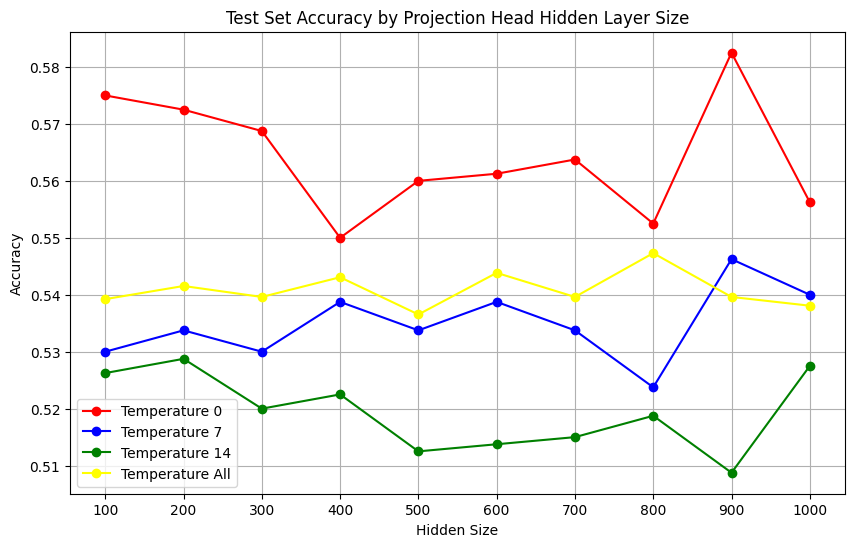

In [136]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(hidden_size_df.index, hidden_size_df['temp_0'], label='Temperature 0', color='red', marker='o')
plt.plot(hidden_size_df.index, hidden_size_df['temp_7'], label='Temperature 7', color='blue', marker='o')
plt.plot(hidden_size_df.index, hidden_size_df['temp_14'], label='Temperature 14', color='green', marker='o')
plt.plot(hidden_size_df.index, hidden_size_df['temp_all'], label='Temperature All', color='yellow', marker='o')


plt.title('Test Set Accuracy by Projection Head Hidden Layer Size')
plt.xlabel('Hidden Size')
plt.ylabel('Accuracy')
plt.xticks(hidden_size_df.index) 
plt.legend()
plt.grid()
plt.show()

In [137]:
# Analyze supcontemp sensitivity
temps = [0.01, 0.05, 0.10, 0.15, 0.2, 0.25, 0.30]
temp_0_supcon_accuracies = []
temp_7_supcon_accuracies = []
temp_14_supcon_accuracies = []
temp_all_supcon_accuracies = []

for temp in temps:
    temp_0_model = SCL.ModelGenerator(SCL.data_loader_0_train, SCL.data_loader_0_test)
    temp_0_model.gen_model(128, temp)
    temp_0_supcon_accuracies.append(temp_0_model.test_accuracy(data_loader_0_val))
    temp_7_model = SCL.ModelGenerator(SCL.data_loader_7_train, SCL.data_loader_7_test)
    temp_7_model.gen_model(128, temp)
    temp_7_supcon_accuracies.append(temp_7_model.test_accuracy(data_loader_7_val))
    temp_14_model = SCL.ModelGenerator(SCL.data_loader_14_train, SCL.data_loader_14_test)
    temp_14_model.gen_model(128, temp)
    temp_14_supcon_accuracies.append(temp_14_model.test_accuracy(data_loader_14_val))
    temp_all_model = SCL.ModelGenerator(SCL.data_loader_all_train, SCL.data_loader_all_test)
    temp_all_model.gen_model(128, temp)
    temp_all_supcon_accuracies.append(temp_all_model.test_accuracy(data_loader_all_val))

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [04:07<00:00, 24.70s/it]


In [138]:
data = {'temp_0':temp_0_supcon_accuracies, 'temp_7':temp_7_supcon_accuracies, 'temp_14':temp_14_supcon_accuracies, 
        'temp_all':temp_all_supcon_accuracies}
supcon_temp_df = pd.DataFrame(data)
supcon_temp_df.index = temps

In [144]:
supcon_temp_df.drop(supcon_temp_df.tail(1).index,inplace=True)

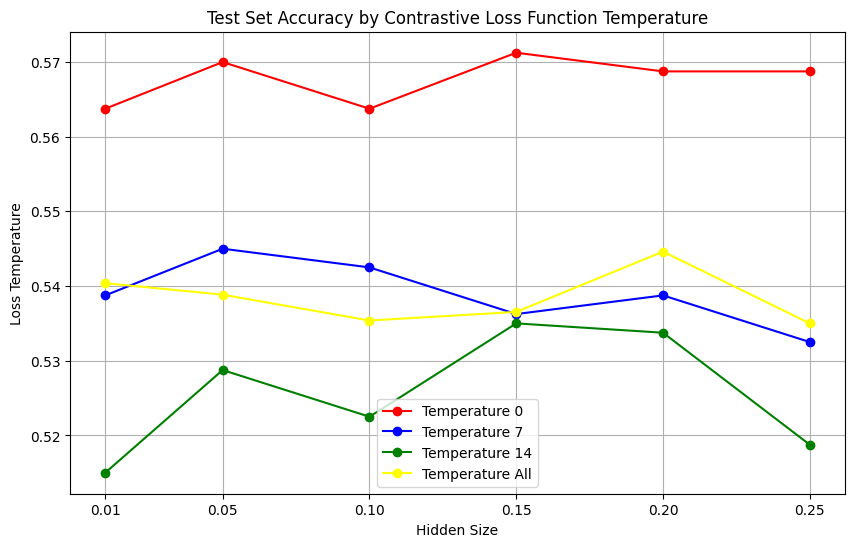

In [146]:
plt.figure(figsize=(10, 6))
plt.plot(supcon_temp_df.index, supcon_temp_df['temp_0'], label='Temperature 0', color='red', marker='o')
plt.plot(supcon_temp_df.index, supcon_temp_df['temp_7'], label='Temperature 7', color='blue', marker='o')
plt.plot(supcon_temp_df.index, supcon_temp_df['temp_14'], label='Temperature 14', color='green', marker='o')
plt.plot(supcon_temp_df.index, supcon_temp_df['temp_all'], label='Temperature All', color='yellow', marker='o')


plt.title('Test Set Accuracy by Contrastive Loss Function Temperature')
plt.xlabel('Hidden Size')
plt.ylabel('Loss Temperature')
plt.xticks(supcon_temp_df.index) 
plt.legend()
plt.grid()
plt.show()